# End-to-end Machine Learning project

透過一個端點到端點的案例，來進行機器學習的項目。

會經歷以下主要步驟：
1. 觀察大局
2. 獲得數據
3. 從數據探索和可視化中獲得洞見
4. 機器學習算法的數據準備
5. 選擇和訓練模型
6. 微調模型
7. 展示解決方案
8. 啟動、監控和維護系統

# Working with Real Data

在本章是從 StatLib 中選擇 California Housing Price 數據集。 該數據集是基於 1990 年加利福尼亞人口普查的數據。 另外針對該數據集還添加了一個分類屬性，並删除了一些特徵。

# Look at the Big Picture

目的是要從數據中訓練出個模型，能夠根據所有其他的指標，預測任意區域的房價中位數。

## Frame the Problem

第一個問題應該是要詢問"業務目標是什麼"，因為建立模型本身不是最終的目標，公司期望知道如何使用這個模型，如何從中獲益？這才是最重要的問題。

第二個問題是目前的解決方案(如果有的話)為何。這可以當作參考，也可從中獲得解決問題的洞察。

有了以上的資訊，就可以開始設計系統。首先，需要回答框架性問題，是監督式？還是非監督式？又或是強化學習？是分類任務、迴歸任務還是其他任務？應該使用批量學習還是在線學習技術？

**Pipeline**

一個序列的數據處理組件稱為一個數據流水線（Pipeline）。組件通常是異步運行。每個組件拉取大量的數據進行處理，再將結果傳給另一個數據倉庫，之後流水線中的下一個組件拉取前面的數據，並給出自己的輸出。每個組件都很獨立：組件和組件之間的連接只有數據倉庫。這使得不同團隊可以專注於不同的組件上。如果某個組件發生故障，其下游組件也還能使用前面最後一個輸出繼續運行一段時間，使得整個架構魯棒性較強。

但這也表示需要適當的監控，以免造成壞掉的組件都無人發現，導致過期的數據影響整個系統的效能。

## Select a Performance Measure

迴歸問題的典型性能衡量指標是均方根誤差(RMSE)，這是測量預測過程中，預測錯誤的標準偏差。  
（標準偏差($\sigma$)，通常用 sigma 來表示，是方差的算數平方根，而方差是離均平方差的平均數）

RMSE 公式：

$RMSE(X, h) =  \sqrt{\frac{\sum_{i=1}^{m}(h(x^i)- y^i)^2}{m}} $

m：數據中實例的數量  
$x^i$：第 i 個實例的所有特徵值的向量（標籤特徵除外）
$y^i$：指的是標籤，也就是期待該實例的輸出值
X：是數據中所有實例的所有特徵值的矩陣，每個實例為一列  
h：是系統的預測函數，也稱為一個假設。當給定一個實例的特徵向量 $x^i$，會輸出一個預測值 $\hat y^i = h(x^i)$  
RMSE(X, h)：使用假設 h 在示例上測量的成本函數

常見的分佈為呈現鐘型型態的分佈，稱為常態分佈、正態分佈（也稱為高斯分佈），“68-95-99.7“的規則指的是，大約68%的直落在1$\sigma$內，95%的直落在2$\sigma$內，99.7%的直落在3$\sigma$內。

當有很多離群區域時，可以考慮使用平均絕對誤差（也稱為平均絕對偏差）。

MAE 公式：

$MAE(X, h) = \frac{\sum_{i=1}^{m}|h(x^i)- y^i|}{m}$

均方根誤差和平均絕對誤差兩種方法都是測量兩個向量間的距離：預測向量和目標值向量。

距離或者範數的測度有很多種：
* 計算平方和的根（RMSE）對應歐幾里德範數：這也稱為 $\ell$2 範數，記作 $||・||_2$（或者||・||）
* 計算絕對值得總和（MAE）對應 $\ell$1 範數，記作 $||・||_1$。有時也稱為曼哈頓距離，因為這是在測量一個城市的兩點之間的距離時，只能沿著正交的城市街區行走
* 包含 n 個元素的向量 vk 的範數可以定義為$||v||_k$ = $(|v_0|^k + |v_1|^k + ... + |v_m|^k)^\frac{1}{m}$・$\ell_0$ 僅給出了向量的基數（即元素的數量），$\ell_\infty$給出了向量中的最大絕對值。
* 範數指數越高，則越關注大的價值，忽視小的價值。這也是為何 RMSE 比 MAE 對異常值更敏感。但當異常值非常稀少（如鐘形曲線）時，RMSE的表現優異，通常作為首選。

## Check the Assumptions

列舉和驗證到目前為止所有人(包含自己)所做出的假設，這可以在初期檢查出嚴重問題，而不會之後都開始建構系統時才發現問題。

# Get the data

## Download the Data

In [1]:
import os
import tarfile
from six.moves import urllib

In [2]:
DOWNLOAD_ROOT = 'https://github.com/ageron/handson-ml/raw/master/'
HOUSING_PATH = 'datasets/housing'
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + '/housing.tgz'

In [3]:
def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
        
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path = housing_path)
    housing_tgz.close()

使用 fetch_housing_data()，會自動在工作區中創建一個 datasets/houing 目錄，然後下載 housing.tgz 文件，並將 housing.csv 解壓縮到這個目錄。

In [4]:
fetch_housing_data()

使用 Pandas 來載入數據，利用所寫的函數來載入數據。

In [5]:
import pandas as pd

In [6]:
# This function returns a Pandas DataFrame object containing all the data.
# 此函數返回一個包含所有數據的 pandas 數據結構
def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    
    return pd.read_csv(csv_path)

## Take a Quick Look at the Data Structure

利用 .head() 輸出前五列的數據和表頭

In [7]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


以上資料中，每列表示一個區域，共有 10 個屬性。

利用 .info() 輸出每個特徵的總個數及資料類型等資訊

In [8]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


數據中包含 20,640 個實例。

total_bedrooms 這個屬性只有 20,433 個非空值，表示有 207 個區域遺失這個特徵。

所以屬性都是數值，只有 ocean_proximity 的類型是 object，因此可以是任何類型的 Python 物件。但因為從 csv 文件中載入該數據，因此應該就是文本屬性，且從前五列的資料中看到有重複的情況，因此可以認定為一個分類屬性。

使用 .value_counts() 統計特徵中每個元素的總個數

一般用在統計有限個元素的特徵

In [9]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

.describe()看實數特徵的統計資訊

可以看實數特徵的最大值、最小值、平均值、方差、總個數、25%、50%、75%

std表示標準差（用來測量數值的離散程度)

25%、50%、75%表示相對應的百分位數，百分位數表示一組觀測值中，給定百分比的觀測值都低於該值  
通常稱第 25 百分位數為第 1 四分位數，第 25 百分位數中位數和第 75 百分位為第 3 個四分位數

**注意是這邊的空值會被忽略**  
（例如，total_bedrooms 的計數為20,433，而不是 20,640）

In [10]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


hist() 輸出實數域的直方圖

直方圖用來顯示給定值範圍（橫軸）的實例數量（縱軸）。

透過 hist() 生成直方圖，能夠查看實數特徵元素的分佈情況

In [11]:
import matplotlib.pyplot as plt

%matplotlib inline

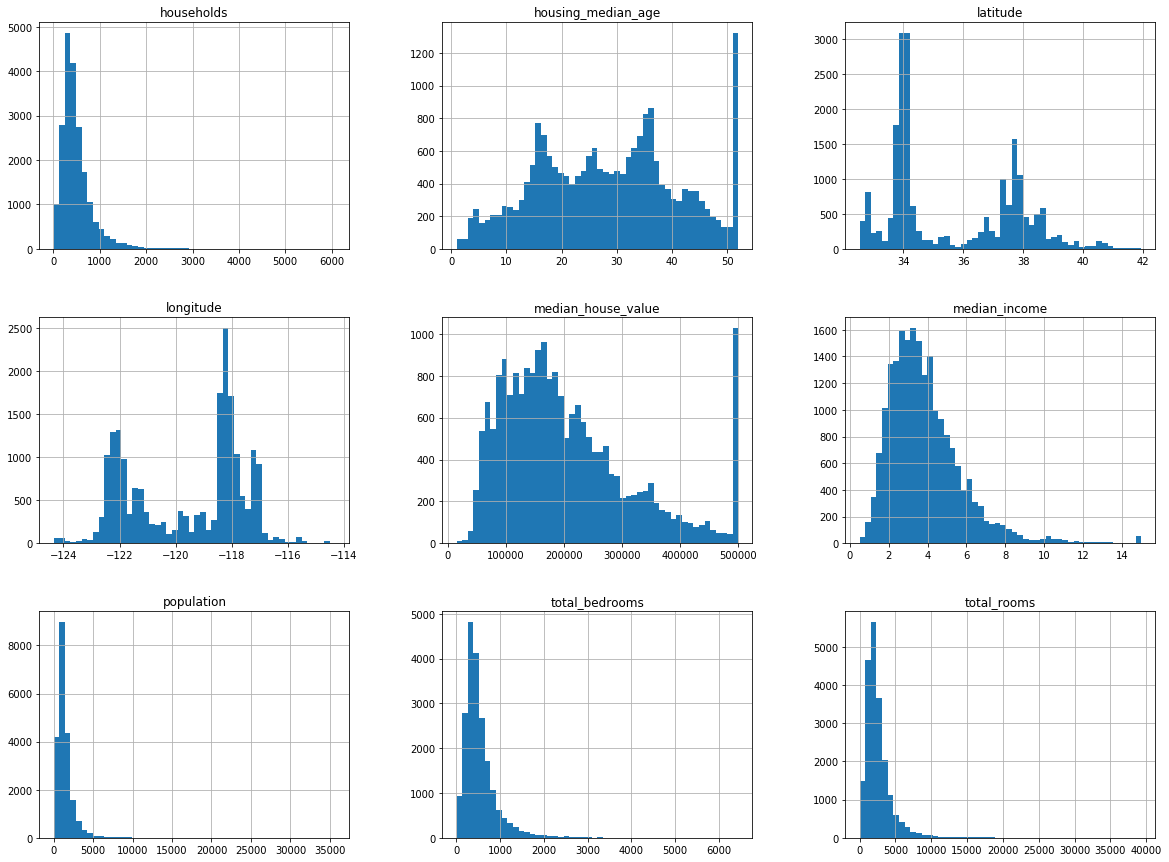

In [12]:
housing.hist(bins = 50, figsize = (20, 15))

plt.show()

觀察這些直方圖中的一些内容：
1. 收入中位數屬性看起来不像以美元表示（USD）。此數據已經按比例縮小，中位數的上限為15（實際為 15.0001），下限為 0.5（實際為 0.4999）。
2. 房屋年齡中位數和房屋價格中位數也受到限制。後者可能是個嚴重的問題，因为此數據是目標屬性（即標籤）。機器學習算法可能會學習到價格永遠不會超過這個限制。如果需要精确的預測，甚至超過 50 萬美元的部分也需要，那主要有兩種選擇：
 * 對那些標籤植被設置上限的區域，重新收集適當的標籤
 * 從訓練集中删除這些區域的數據（包括從測試集中刪除，因为如果預測值超過 500,000，則系統不應被評估為不良）
3. 這些屬性的尺度差别很大。
4. 許多直方圖都是呈現重尾：圖形在中位數右側的延伸比左側要遠得多。這可能會導致某些機器學習算法難以檢測模式。

# Create a Test Set

如果瀏覽數據集，可能會偶然發現數據中一些看似有趣的模式，導致選擇一種特定類型的機器學習模型。 當使用測試集對泛化誤差率進行評估時，估計結果將會過於樂觀，該系統起度後的表現將不如預測那般優秀，這稱為**數據窺探偏差**。

自寫函數來拆分訓練與測試資料

In [13]:
import numpy as np

In [14]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [15]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    
    return data.iloc[train_indices], data.iloc[test_indices]

In [16]:
train_set, test_set = split_train_test(housing, 0.2)

In [17]:
print(len(train_set), 'train +', len(test_set), 'test')

16512 train + 4128 test


雖然可正確的分開訓練、測試，但如果重新運行程式，訓練和測試集會不一樣。假設在原來模型的基礎上繼續訓練，但不能保證測試及沒有被模型訓練過，因此不能驗證模型效果。有兩種方案：

方案一：使用 shuffle 之前，使用 np.random.seed(42)，則每次運行 shuffle 的結果一樣(訓練、測試集一樣)。但如果新增一些數據集，則此方案不可行。

方案二：解決方案一的方法，採用每個樣本的識別碼(用 ID 或是行號)來決定是否放入測試集。

下次獲取更新的數據集時，上面兩種解決方案都會中斷。 常見的解決方案是：

使用每個實例的標識碼來決定是否應該進入測試集（假設實例具有唯一且不可變的標識碼）。例如，可以計算識別碼的 hash 值，取 hash 值的最後一個字節（0~255），如果該值小於一個數，如51（256的20%，20% * 256）則放入測試集。這樣可確保測試集在多個運行裡都是一致的，即使更新數據集也仍一致。新實例的 20% 將被放入新的測試集，而之前訓練集中的實例也不會被放入新測試集。

In [18]:
import hashlib

In [19]:
def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

In [20]:
def split_train_test_by_id(data, test_ratio, id_column, hash = hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    
    return data.loc[~in_test_set], data.loc[in_test_set]

但由於 housing 數據沒有標示碼行，使用列索引作為 ID

In [21]:
housing_with_id = housing.reset_index()    # adds an 'index' column

In [22]:
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')

In [23]:
train_set.shape

(16362, 11)

In [24]:
train_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
6,6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY


In [25]:
test_set.shape

(4278, 11)

In [26]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY
20,20,-122.27,37.85,40.0,751.0,184.0,409.0,166.0,1.3578,147500.0,NEAR BAY
23,23,-122.27,37.84,52.0,1688.0,337.0,853.0,325.0,2.1806,99700.0,NEAR BAY


使用列索引作為唯一標識碼，必須確保是在數據集的末尾添加新數據，且不會刪除任何列，如果不行，就必須另外找穩定的特徵來創建為一的識別碼

以下使用地區的經緯度(longitude和latitude)來組合成一個 ID

需要**注意**的是：位置資訊實際上非常粗糙，因此許多區域將具有完全相同的 ID，因此它們將最終位於同一組（測試或訓練集）中。這引入了一些抽樣偏差。

In [27]:
housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'id')

In [28]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16


使用 Scikit-Learn 的 function 去拆分訓練與測試集

Scikit-Learn 有提供了很多函數可以將數據集拆分為多個子集。 最簡單的函數是 train_test_split，與先前定義的 split_train_test 函數幾乎完全相同，它有兩個額外的參數：
* 有一個 random_state 參數，允許設置如前所述的隨機生成器種子。
* 可以傳遞多個具有相同列數的數據集，並將它們分割在相同的索引上（例如，如果有一個單獨的 DataFrame 用於標記時，這就非常有用）。

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)

# random_state為 0 或沒有時，為每次隨機的情況

In [31]:
train_set.shape

(16512, 10)

In [32]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


In [33]:
test_set.shape

(4128, 10)

如果數據集足夠大，使用純隨機的抽樣方法通常都不錯，但如果數據集不夠大，則可考慮分層抽樣。

分層抽樣，將抽樣對象依照按某種特徵或某種規則劃分為均勻的子集，每個子集都稱為一層，然後從每層抽取正確的實例數量，以確保測試集合代表了抽樣對象其特徵或規則具有相同的比例。

對於預測房屋價格中位數，收入的中位數通常非常重要。會希望確保測試集代表整個數據集中的各種收入水平的人群。

由於收入中位數是連續數字屬性，因此首先需要建構收入類別屬性。

先看一下收入中位數直方圖

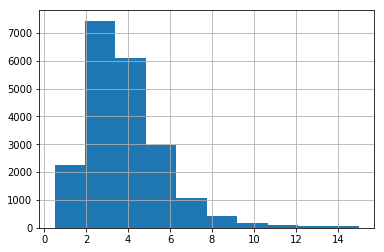

In [34]:
housing['median_income'].hist()

* 大多數收入中位數集中在 2-5（萬美元）左右
* 但是一些收入中位數遠超過 6

**每個階層的數據集中有足够數量的實例非常重要**，不然數據不足的階層，其重要性可能會被錯估。 這意味著不應該將層數分得太多，每個階層應該足夠大才行。

創建收入類別屬性，將收入中位數除以 1.5（限制收入類別的數量），使用 ceil 進行取整（得到離散類別），最後將所有大於 5 的類別合併為類別 5。

創建收入类别属性 - 'income_cat'

In [35]:
# Divide by 1.5 to limit the number of income categories
housing['income_cat'] = np.ceil(housing['median_income'] / 1.5)

In [36]:
# Label those above 5 as 5
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace = True)

In [37]:
# 對收入中位數按照 1 萬美元，2 萬美元，3 萬美元，4 萬美元，5 萬及 5 萬以上進行統計
housing['income_cat'].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

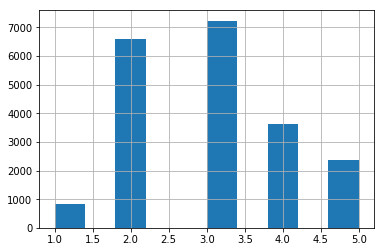

In [38]:
# 對收入中位數做直方圖
housing['income_cat'].hist()

準備好根據收入類別進行分層抽樣。 可以使用 Scikit-Learn 的 Stratified-Shuffle Split（分層隨機拆分）。

In [39]:
from sklearn.model_selection import StratifiedShuffleSplit

In [40]:
split = StratifiedShuffleSplit(n_splits = 1, test_size  = 0.2, random_state = 42)

In [41]:
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

所有住房數據根據收入類別的比例分佈

In [42]:
housing['income_cat'].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

比較完整數據集、分層抽樣的測試集、純隨機抽樣的測試集中收入類別的比例分佈。

結果顯示，分層抽樣的測試集中的比例分佈與完整數據集中的分佈幾乎一致，純隨機抽樣出現重大偏離。

In [43]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

In [44]:
train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)

In [45]:
compare_props = pd.DataFrame({
    'Overall': income_cat_proportions(housing),
    'Stratified': income_cat_proportions(strat_test_set),
    'Random': income_cat_proportions(test_set),
}).sort_index()

In [46]:
compare_props['Rand. %error'] = 100 * compare_props['Random'] / compare_props['Overall'] - 100
compare_props['Strat. %error'] = 100 * compare_props['Stratified'] / compare_props['Overall'] - 100

In [47]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1.0,0.039826,0.039729,0.040213,0.973236,-0.243309
2.0,0.318847,0.318798,0.324370,1.732260,-0.015195
3.0,0.350581,0.350533,0.358527,2.266446,-0.013820
4.0,0.176308,0.176357,0.167393,-5.056334,0.027480
5.0,0.114438,0.114583,0.109496,-4.318374,0.127011


刪除income_cat屬性，將數據恢復原樣

In [48]:
for set in (strat_train_set, strat_test_set):
    set.drop(['income_cat'], axis = 1, inplace = True)

# Discover and visualize the data to gain insights

創建一個訓練集數據副本，這樣就可以在不損害訓練集的情況下探索它

In [49]:
train_housing = strat_train_set.copy()

# 防止誤操作，避免查看時修改了訓練集，因此複製一份

In [50]:
train_housing.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN
19480,-120.97,37.66,24.0,2930.0,588.0,1448.0,570.0,3.5395,127900.0,INLAND
8879,-118.50,34.04,52.0,2233.0,317.0,769.0,277.0,8.3839,500001.0,<1H OCEAN
13685,-117.24,34.15,26.0,2041.0,293.0,936.0,375.0,6.0000,140200.0,INLAND
4937,-118.26,33.99,47.0,1865.0,465.0,1916.0,438.0,1.8242,95000.0,<1H OCEAN
4861,-118.28,34.02,29.0,515.0,229.0,2690.0,217.0,0.4999,500001.0,<1H OCEAN


## Visualizing Geographical Data

由於有地理信息（緯度和經度），所以創建所有區域的散佈圖來可視化數據化。

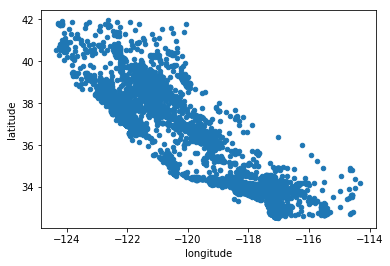

In [51]:
train_housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude')

# x 軸表緯度，y 軸表經度

將 alpha 參數設置為0.1（參數 alpha 決定圖表的填充不透明度，範圍[0,1]，預設值是 1 ）可以更容易地顯示存在高密度數據點的地方。

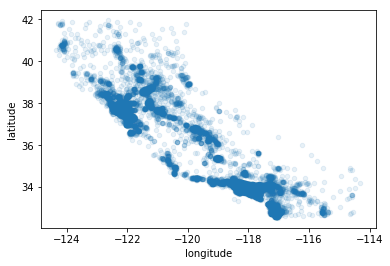

In [52]:
train_housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha  = 0.1)

alpha 設為 1，則和前一個圖一樣。alpha 越靠近 0 只加深越高密度的地方。

現在來看房價：
* 每個圓的半徑代表區域的人口（選項 s）。
* 顏色代表價格（選項 c）。
* 使用一個名為 jet 的預設定義顏色圖（選項 cmap），範圍從藍色（低）到紅色（高）。

s 表某參數圓的半徑，c 用於對某參數顯示顏色，cmap 表示一個 colormap，jet 為藍到紅的顏色，colorbar 為右側顏色條。

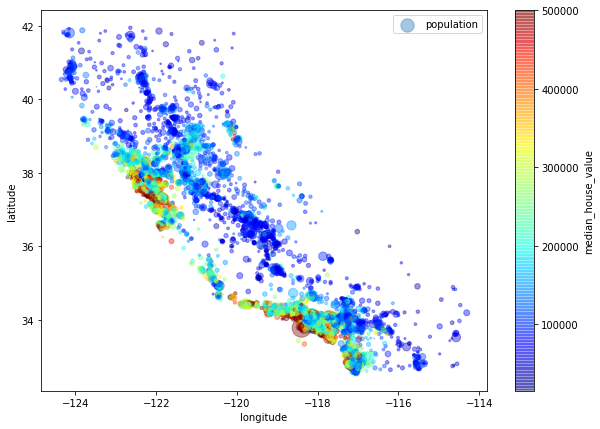

In [53]:
train_housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = 0.4,
    s = housing['population'] / 100, label = 'population', figsize = (10, 7),
    c = 'median_house_value', 
    cmap = plt.get_cmap('jet'), colorbar = True, sharex = False)

plt.legend()

從此圖可知，
* 房價與位置有很大關係（例如，靠近海洋）和人口密度也有很大關係。因此使用聚類算法來檢測主群體可能是有用的，再為各個聚類中心添加一個新的衡量鄰近距離的特徵。
* 海洋鄰近屬性也可能有用，但在北加州沿海地區的房價不是太高，所以這個簡單的規則也不是萬能。

（這部分書中沒有，在作者的github中才有）

下面是將上圖放在加利福尼亞的地圖之上，執行前需要在圖片保存路徑中提前保存一張加州地圖，以便讀取

In [54]:
import matplotlib.image as mpimg

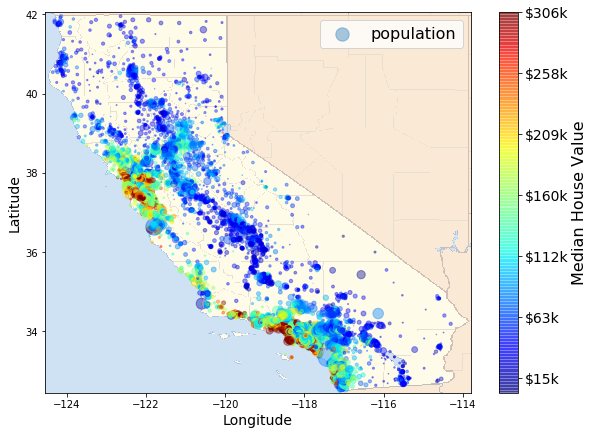

In [55]:
california_img = mpimg.imread('./images/end_to_end_project/california.png')

ax = housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude', figsize = (10, 7),
                       s = housing['population'] / 100, label = 'population',
                       c = 'median_house_value', 
                       cmap = plt.get_cmap("jet"),
                       colorbar = False, 
                       alpha = 0.4
                      )

plt.imshow(california_img, extent = [-124.55, -113.80, 32.45, 42.05], alpha = 0.5, cmap = plt.get_cmap('jet'))
plt.ylabel('Latitude', fontsize = 14)
plt.xlabel('Longitude', fontsize = 14)

prices = housing['median_house_value']
tick_values = np.linspace(prices.min(), prices.max(), 11)

cbar = plt.colorbar()
cbar.ax.set_yticklabels(['$%dk' % (round(v / 1000)) for v in tick_values], fontsize = 14)
cbar.set_label('Median House Value', fontsize = 16)

plt.legend(fontsize = 16)
#save_fig('california_housing_prices_plot')

plt.show()

## Looking for Correlations

查看特徵間的相關性

使用 corr() 計算出每對屬性間的標準相關係數（皮爾森相關係數）

In [56]:
corr_matrix = train_housing.corr()

每個屬性與房屋中位數的相關性

In [57]:
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

相關係數範圍從-1到1

* **越接近1**，表示越強的**正相關**; 例如，當收入**中位數上升**時，**房屋中位數**價值往往會**上升**。

* **越接近-1**，表示越強的**負相關**; 可以在**緯度**和**房價中位數**間看到一個小的**負相關**（即當往北時，價格略有**下跌趨勢**)。

* **接近0**，表示**不相關**，意味著沒有線性相關 。

下圖顯示了各種圖以及它們的水平軸和垂直軸之間的相關係數
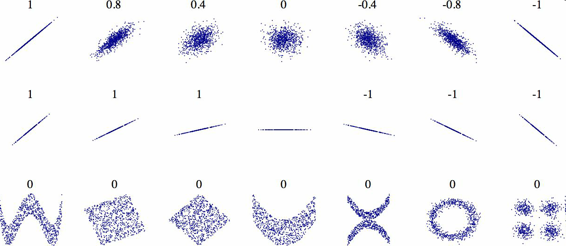

**注意**：

1. 相關係數**僅計算線性相關性**（“如果 x 上升，則 y 通常上升/下降”）。**而特徵之間可能是非線性的關係**，因此需要畫出圖來看一下變量間是否相關。
2. 注意底行的所有圖都具有**等於0**的相關係數，儘管其軸明顯不是獨立的：這些是**非線性關係**的例子 。
3. 此外，第二行顯示出了相關係數等於 1 或 -1 的例子; 要注意，這與**斜率**無關。

使用 pandas 的 scatter_matrix，繪製出每個數值屬性相對於其他數值屬性的相關性。

這裏只關注一些看似與房價中位數最相關的，可算是最有潛力的屬性。

In [58]:
from pandas.plotting import scatter_matrix

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x121744518>,
      dtype=object)

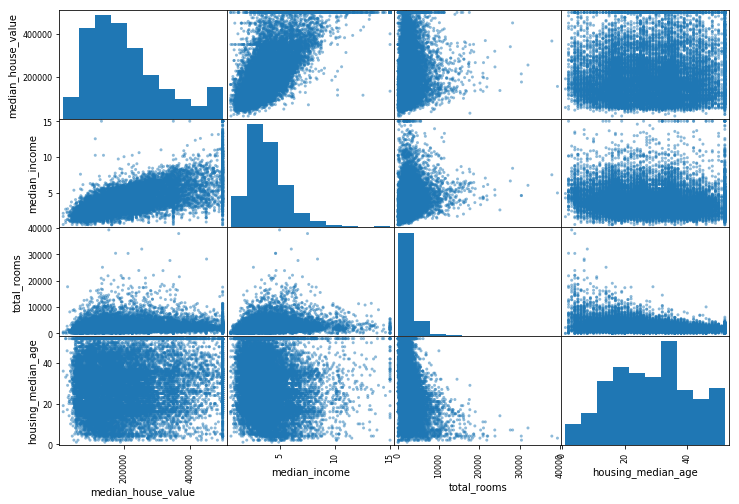

In [59]:
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(train_housing[attributes], figsize = (12, 8))

如果 Pandas 對每個變量自身繪製相關性圖表，那主對角線（從左上角到右下角）將充滿直線，這不是非常有用。 因此，Pandas 會顯示每個屬性的直方圖（有其他選項可用;詳细信息，可参考 Pandas 的文件）。

根據上面兩種查看相關性的方法得到的結果，最有潛力預測房價中位數的屬性是收入中位數，放大看其相關性的散點圖。

[0, 16, 0, 550000]

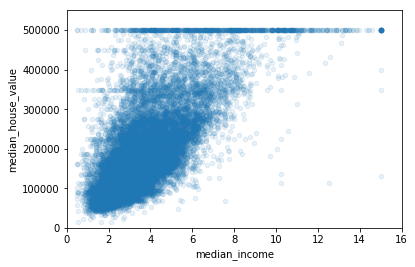

In [60]:
train_housing.plot(kind = 'scatter', x = 'median_income', y = 'median_house_value', alpha = 0.1)
plt.axis([0, 16, 0, 550000])

由上圖可以看出：
 * 首先，相關性確實很强; 可以清楚地看到上升趨勢並且這些點不是太分散。
 * 第二，之前注意到的價格上限清晰可見，大概為 500,000 美元的水平線。
 * 從這裡還可以看出其他不太明顯的幾條直線：一條約 450,000 美元的水平線，另一條約 350,000 美元的水平線，280,000 美元附近似乎隱約也有一條，再往下可能還有一些。
 
為避免算法學習之後重現這些怪異的數據，可能會嘗試刪除這些相應地區。

## Experimenting with Attribute Combinations

在準備給機器學習算法輸入數據之前，要做的最後一件事應該是嘗試各種屬性的組合，例如，
* 在一個地區，如果不知道一個地區有多少家庭，那知道一個地區的房間總數就不是很有用。真正想要知道的是每一個家庭的房間數量。
* 同理，單看臥室總數本身並不是很有意義，可能想把它與房間總數來對比，或拿著同每個家庭的人口數這個屬性結合似乎有意思。

In [61]:
# 每個家庭平均擁有的房間數 = 總房間數 / 總的家庭數
train_housing['rooms_per_household'] = train_housing['total_rooms'] / train_housing['households']

# 總卧室數 / 總房間數 
train_housing['bedrooms_per_room'] = train_housing['total_bedrooms'] / train_housing['total_rooms']

# 平均家庭人口數 = 總人口 / 總家庭數
train_housing['population_per_household'] = train_housing['population'] / train_housing['households']

Note: there was a bug in the previous cell, in the definition of the rooms_per_household attribute. This explains why the correlation value below differs slightly from the value in the book (unless you are reading the latest version).

In [62]:
# 查看新的屬性的相關係數
corr_matrix = train_housing.corr()
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

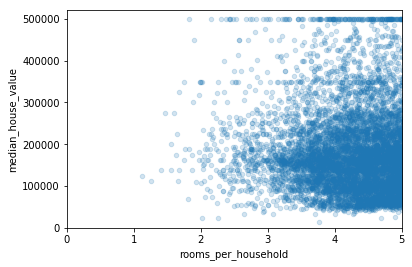

In [63]:
# 繪製散佈圖
train_housing.plot(kind = 'scatter', x = 'rooms_per_household', y = 'median_house_value', alpha = 0.2)
plt.axis([0, 5, 0, 520000])

plt.show()

In [64]:
train_housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724,5.440341,0.212878,3.096437
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830,2.611712,0.057379,11.584826
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000,4.442040,0.175304,2.431287
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000,5.232284,0.203031,2.817653
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000,6.056361,0.239831,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


結果顯示：
* 新的 bedroom_per_room 屬性與房屋中位數值的相關性遠高於房間總數或是卧室總数 - 顯然，卧室/房間比率更低的房屋，往往價格更貴。
* 每個家庭的房間數量也比一個地區的房間總數更具有信息量 - 顯然房屋越大，價格就越貴。


這樣的做法，重點是在用正確的方法，快速獲得對數據的的理解，這有助於獲得第一個合理的原型。 這也是一個不斷迭代的過程：一旦原型產生並且開始運行，可以分析其輸出以洞悉更多的見解，之後再次回到這個探索的步驟。

# Prepare the data for Machine Learning algorithms

現階段是給機器學習算法準備數據了，這時應該透過編寫函數來執行此操作，而不僅僅是手動執行此操作，原因如下：
* 可在任何數據集上輕鬆重現這些轉換（例如，獲得更新的數據庫之後）。
* 利用逐步建構起一個轉換函數的函數庫，在以後的項目中可以重複使用。
* 可以在實時系統（live system）中使用這些函數來轉換新數據，再餵給算法。
* 可輕鬆嘗試各種轉換並查看哪種轉換組合效果最好。

先回到一個乾淨的訓練集（透過再次調用 strat_train_set），並且將預測變量和標籤分開，因為不一定對它們使用相同的轉換方式（需注意，drop() 創建了一個數據副本，但不影響 strat_train_set）。

In [65]:
# 將 'median_house_value' 一行去掉，同時創建數據副本，作為訓練集
housing = strat_train_set.drop('median_house_value', axis = 1)

# 創建數據集標籤：'median_house_value' 即為標籤
housing_labels = strat_train_set['median_house_value'].copy()

In [66]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN


In [67]:
housing.shape

(16512, 9)

以下代碼抽樣取出部分新創建的訓練集中的實例，查看表頭信息，驗證 'median_house_value' 是否被去掉，如果被去掉，每個實例的屬性應該只剩下 9 個，因為原來是 10 個。

In [68]:
sample_incomplete_rows = housing[housing.isnull().any(axis = 1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


## Data Cleaning

大多數機器學習算法無法處理缺失值，所以需要創建一些函數來處理。 在前面注意到 total_bedrooms 這個屬性有些缺失值，所以要來解決這個問題。 有以下三個選擇：
 * 放棄這些相應的地區 - Get rid of the corresponding districts.
 * 放棄這個屬性 - Get rid of the whole attribute.
 * 將缺失值設置為某個值（零，平均數或者中位數等）- Set the values to some value (zero, the mean, the median, etc.).

可以使用 DataFrame 的 dropna()，drop() 和 fillna() 來完成這些操作。

注意：以下三個 cell 是對三個選擇的使用展示，所以均使用上面剛抽樣取出的新訓練集的實例，這樣真實的訊練集並没有受到影響。

去掉含有缺失值的個體（dropna）

In [69]:
sample_incomplete_rows.dropna(subset = ['total_bedrooms'])     # option 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


去掉含有缺失值的整個特徵（drop）

In [70]:
sample_incomplete_rows.drop('total_bedrooms', axis = 1)     # option 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,<1H OCEAN


給缺失值補上一些值（0、平均數、中位數等）（fillna）

In [71]:
median = housing['total_bedrooms'].median()
sample_incomplete_rows['total_bedrooms'].fillna(median, inplace = True)     # option 3
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN


Scikit-Learn 有對缺失值處理的 **Imputer**

首先，需要創建一個 **Imputer** 物件，並且**指定要用属性的中位數值替換該屬性的缺失值**。

In [72]:
from sklearn.preprocessing import Imputer

In [73]:
# 使用 Imputer 函數需要先定義一個補缺失值的策略（如 median）
imputer = Imputer(strategy = 'median')

/Users/jasonch/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [74]:
# Remove the text attribute because median can only be calculated on numerical attributes:
# ocean_proximity 這一行是文本屬性，而中位數只能在數值類屬性上計算，所以需要創建一個没有 ocean_proximity 的數據副本，把這一行去掉，然後再補缺失值
housing_num = housing.drop('ocean_proximity', axis = 1)

In [75]:
housing_num.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [76]:
housing_num.shape

(16512, 8)

雖然只有 'total_bedrooms' 屬性具有缺失值，但無法確定系統上線後新數據中是否會存在任何缺失值，因此將 imputer 應用於所有的數值屬性。

In [77]:
# 使用 fit() 將 imputer 物件 fit 到訓練數據
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

imputer 是計算每個屬性的中位數值，並將結果存在其實例變量 statistics_ 中。

In [78]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Check that this is the same as manually computing the median of each attribute:

In [79]:
# 利用手工計算方法（將 housing_num 取.median().values）檢查和用 imputer 計算的結果是否相等。結果是一至的。
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Transform the training set

使用 imputer 透過學習得到的中位數替換缺失值來對訓練集進行轉換。

對數據缺失值補全以後，一般需要轉化為 Numpy 的矩陣格式，方便模型的输入，所以可以調用 Imputer 的 transform() 方法。

fit 和 transform 也可以合起來使用，即 fit_transform()，這個函數會比分開調用要快一些。

In [80]:
X = imputer.transform(housing_num)
#X = imputer.fit_transform(housing_num)

In [81]:
Ｘ

array([[-121.89  ,   37.29  ,   38.    , ...,  710.    ,  339.    ,
           2.7042],
       [-121.93  ,   37.05  ,   14.    , ...,  306.    ,  113.    ,
           6.4214],
       [-117.2   ,   32.77  ,   31.    , ...,  936.    ,  462.    ,
           2.8621],
       ...,
       [-116.4   ,   34.09  ,    9.    , ..., 2098.    ,  765.    ,
           3.2723],
       [-118.01  ,   33.82  ,   31.    , ..., 1356.    ,  356.    ,
           4.0625],
       [-122.45  ,   37.77  ,   52.    , ..., 1269.    ,  639.    ,
           3.575 ]])

結果是一個包含轉換特徵的Numpy數組。

可以將 Numpy 格式的轉換為 Pandas DataFrame 格式。

In [82]:
housing_tr = pd.DataFrame(X, columns = housing_num.columns, index = list(housing.index.values))
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [83]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662


In [84]:
imputer.strategy

'median'

In [85]:
housing_tr = pd.DataFrame(X, columns = housing_num.columns)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


In [86]:
housing_tr.shape

(16512, 8)

## Handling Text and Categorical Attributes

處理類别文本特徵

In [87]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


由於 'ocean_proximity' 這個屬性是屬於文本类的屬性，無法作median等操作，所以需要將文本特徵編碼成實數特徵，對應 Scikit-Learn 中為 LabelEncoder，再使用 fit_transform() 方法將文本特徵編碼。

In [88]:
from sklearn.preprocessing import LabelEncoder

In [89]:
encoder = LabelEncoder()
housing_cat = housing['ocean_proximity']
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3])

使用 categories_ 屬性來查看這個編碼器學習到的映射，如 OCEAN 對應為 0，INLAND 對應為 1，等等。

In [90]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


這在作者的 github 針對這部份所修改與書中程式碼不同處。

**Warning**: earlier versions of the book used the `LabelEncoder` class or Pandas' `Series.factorize()` method to encode string categorical attributes as integers. However, the `OrdinalEncoder` class that is planned to be introduced in Scikit-Learn 0.20 (see [PR #10521](https://github.com/scikit-learn/scikit-learn/issues/10521)) is preferable since it is designed for input features (`X` instead of labels `y`) and it plays well with pipelines (introduced later in this notebook). For now, we will import it from `future_encoders.py`, but once it is available you can import it directly from `sklearn.preprocessing`.

In [ ]:
#from sklearn.preprocessing import OrdinalEncoder

In [ ]:
#ordinal_encoder = OrdinalEncoder()
#housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
#housing_cat_encoded[:10]

In [ ]:
#ordinal_encoder.categories_

以上方法的結果，會讓機器學習算法以為兩個相近的數字比兩個較遠的數字更為相似一些，例如 0 到 1 的距離比 0 到 3 的距離要近，所以這數字編碼隱含了 0 和 1 的相似性比 0 到 3 的相似性要强，但原先此屬性內的元素其意義並非如此，每個元素的相似性應趨於相等。

常見的解決方法是為每個類別創建一個二進制屬性：
* 當類別為 '<1H OCEAN' 時，一個屬性等於 1（其他為 0）。
* 當類別為 'INLAND' 時，另一個屬性等於 1（ 其他為 0），以此類推。

這就是 **one-hot encoding** ，因為只有一個屬性等于 1（hot），而其他屬性為 0（cold）。

可對應 Scikit-Learn 中的 OneHotEncoder，可以將整數分類值轉換為 one-hot 向量。

In [91]:
from sklearn.preprocessing import OneHotEncoder

In [92]:
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1, 1))
housing_cat_1hot

/Users/jasonch/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

預設的輸出結果為稀疏矩陣（sparse matrix），而不是 Numpy，由於矩陣大部分為 0 浪費空間，所以使用稀疏矩陣存放。想看矩阵的具體樣子，可以透過使用 toarray() 將其轉換為密集數組 dense matrix（Numpy）。

In [93]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

上述方法先透過將文本類別做數字編碼，再轉為 one-hot 編碼共用了兩步驟，也可以使用 LabelBinarizer 一次性完成這兩種轉換，直接從文本類別到 one-hot 向量。

In [94]:
from sklearn.preprocessing import LabelBinarizer

In [95]:
encoder = LabelBinarizer()
#encoder = LabelBinarizer(sparse_output = True)     #預設輸出的是Numpy矩陣，可透過設定sparse_output = True來得到稀疏矩陣
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

這輸出的結果直接就是一個密集的 Numpy 數組，若要得到稀疏矩陣，可建立 LabelBinarizer 物件時，透過設定 sparse_output = True 來取得。

## 自動轉換器

由於 Scikit-Learn 中的函數所提供的 Transformer 方法不一定適用於真實情形，所以有時需要自定義一個 Transformer，與 Scikit-Learn 能够做到“無縫結合”。

由於 Scikit-Learn 依賴於 duck typing（不是繼承），所以需要創建一個 Class 並實現三個函數：
 * fit() 返回 self()
 * transform()
 * fit_transform()

最後一個只需要添加 TransformerMixin 作为基類即可實現。 此外，如果将 BaseEstimator 加為基類（並避免構造函數中的 * args 和 ** kargs），可以獲得兩個額外的方法（get_params()和 set_params()），这些對自動調整超參數很有用。


定義類時需要加入基礎類：BaseEstimator（必須），以及 TransformerMixin（用於自動生成fit_transformer()方法）。

下面的例子：是用於增加組合特徵的 Trainsformer

In [96]:
from sklearn.base import BaseEstimator, TransformerMixin

In [97]:
# column index-行索引
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

In [98]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):       # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    
    def fit(self, X, y = None):
        return self     # nothing else to do
    
    def transform(self, X, y = None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [99]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room = False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [100]:
housing_extra_attribs

array([[-121.89, 37.29, 38.0, ..., '<1H OCEAN', 4.625368731563422,
        2.094395280235988],
       [-121.93, 37.05, 14.0, ..., '<1H OCEAN', 6.008849557522124,
        2.7079646017699117],
       [-117.2, 32.77, 31.0, ..., 'NEAR OCEAN', 4.225108225108225,
        2.0259740259740258],
       ...,
       [-116.4, 34.09, 9.0, ..., 'INLAND', 6.34640522875817,
        2.742483660130719],
       [-118.01, 33.82, 31.0, ..., '<1H OCEAN', 5.50561797752809,
        3.808988764044944],
       [-122.45, 37.77, 52.0, ..., 'NEAR BAY', 4.843505477308295,
        1.9859154929577465]], dtype=object)

在這例子中，transformer 設計一個 init 並一個超參數 add_bedrooms_per_room，預設是設置為 True（提供合理的預設值是很有幫助），可以調整是否加入該元素。此超參數允許找出加入此屬性是否有助於機器學習算法。 用於嘗試確定加入該元素是否對模型效果提升，方便修改，節省時間。

更一般地說，可以利用添加超參數來控制不是 100％ 確定的任何數據準備步驟。 當自動執行這些數據準備步驟的次數越多，可以自動嘗試的組合就越多，就越有可能找到一個很好的組合（並節省大量時間）。

In [101]:
housing_extra_attribs = pd.DataFrame(housing_extra_attribs, columns = list(housing.columns) + ['rooms_per_household', 'population_per_household'])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


In [102]:
housing_extra_attribs.shape

(16512, 11)

## Feature Scaling

除了少數例外，當輸入數字屬性彼此間具有非常不同的比例時，機器學習算法表現會不佳，因為易受到比例大的屬性影響，因此需要應用最重要的轉換是特徵縮放，而通常不需要缩放 target values。

對應Scikit-Learn中的類為：

  1、MinMaxScaler：最小-最大縮放（又稱歸一化），將特徵縮放到 0-1 之間，利用將值減去最小值並除以最大值和最小值的差，但受異常值影響較大。可以用參數feature_range來自定義縮放的範圍，不一定是 0-1。

  2、StandardScaler：標準化，是減去平均值（所以標準畫質的均值總為 0），然後除以方差，其結果沒有綁定特定範圍，異常值的影響較小。

需要注意：每次縮放只能針對訓練集或只是測試集，而不能是整個數據集，這是由於測試集（或新數據）不屬於訓練範圍。

## Transformation Pipelines

上述有非常多的轉換操作，並按一定的順序執行，但是再次處理其他數據（如測試數據）時需要重新調用執行眾多步驟。

所以 Scikit-Learn 提供了 Pineline 來幫助這種一系列的轉換，把這些轉換封裝為一個轉換。

In [103]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [104]:
num_pipeline = Pipeline([
        ('imputer', Imputer(strategy = 'median')),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

/Users/jasonch/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [105]:
housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [106]:
housing_num_tr.shape

(16512, 11)

Pipeline 構造函數會透過一系列 **名稱/估算器(estimator)** 的配對來定義步驟的序列。 除最後一個是 estimator（估算器）之外，前面都必須是 transformers（轉換器）（即，必須有 **fit_transform()** 方法）。 Pipeline 的命名可隨意。

當用 Pipeline 的 **fit（）方法** ，會在所有 transformer 上按照順序依次調用 **fit_transform()** ，將一個調用的輸出作為參數傳遞給下一個調用方法，直到傳遞到最終的 estimator，這里只會調用 **fit()** 方法。

在上面的例子中，最後一個 estimator 是一個 **StandardScaler**，它是一個 transformer，因此 Pipeline 有 **transform()** 方法可以按順序將所有轉換應用到數據中（若不希望先調用 **fit()** 再調用 ** transform()** ，也可以直接調用 **fit_transform()** 方法）。

**Warning**: earlier versions of the book applied different transformations to different columns using a solution based on a `DataFrameSelector` transformer and a `FeatureUnion` (see below). It is now preferable to use the `ColumnTransformer` class that will be introduced in Scikit-Learn 0.20. When Scikit-Learn 0.20 is released, you can import it from `sklearn.compose` instead.

In [107]:
from sklearn.compose import ColumnTransformer

In [108]:
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

In [109]:
full_pipeline = ColumnTransformer([
        ('num', num_pipeline, num_attribs),
        ('cat', OneHotEncoder(), cat_attribs),
    ])

In [110]:
housing_prepared = full_pipeline.fit_transform(housing)

/Users/jasonch/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [111]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [112]:
housing_prepared.shape

(16512, 16)

* 以上是基於 Scikit-Learn 0.20 做出的結果，早期版本是使用基於 DataFrameSelector 轉換器和 FeatureUnion 將不同的轉換應於不同的行。

作為参考，下面是基于DataFrameSelector transformer （選擇 Pandas DataFrame 行的子集）和 FeatureUnion 的舊版解決方案。

現在有了數值 Pipeline，還需要在分類值上應用 LabelBinarizer，可以使用 Scikit-Learn 所提供的一個 FeatureUnion 來將這些轉換加入到單個 Pipeline。

給定一個 transformers 列表（可以是整個 transformer pipelines），當 transform() 被調用時，它會並行運行每個 transformer 的 transform()，等待它們的輸出，然後連接並返回結果（同樣地，調用 fit() 也會調用每個 transformer 的fit()）。

處理數字和分類屬性的完整 Pipeline 如下所示。

In [113]:
from sklearn.base import BaseEstimator, TransformerMixin

In [114]:
# Create a class to select numerical or categorical columns 
# 由於 Scikit-Learn 没有處理 Pandas 數據的 DataFrame，因此需要自己自定義
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values

In [115]:
num_attribs = list(housing_num)     # 數字屬性
cat_attribs = ['ocean_proximity']    # 分類屬性

In [116]:
# 定義數字屬性的 Pipeline
old_num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy = 'median')),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

# 定義分類屬性的 Pipeline
old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse = False)),   # 這是作者在 github 中所用的，是可以正常執行
        #('label_binarizer', LabelBinarizer()),  # 書中是用這個程式碼，但執行會有錯誤，可參考下面說明
    ])

/Users/jasonch/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


就可以透過 FeatureUnion 結合多個 Pineline

In [117]:
from sklearn.pipeline import FeatureUnion

In [118]:
old_full_pipeline = FeatureUnion(transformer_list = [
        ('num_pipeline', old_num_pipeline),
        ('cat_pipeline', old_cat_pipeline),
    ])

In [119]:
old_housing_prepared = old_full_pipeline.fit_transform(housing)
old_housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [120]:
old_housing_prepared.shape

(16512, 16)

In [121]:
np.allclose(housing_prepared, old_housing_prepared)

# np.allclose  test if same shape, elements have close enough values

True

在 Scikit-learn == 0.18.0 及以前版本 LabelBinarizer() 用在 Pineline 没有問題；而在 0.19.0 版本則會報錯，因此需要自己定義一個新的LabelBinarizer_new()，代碼如下；0.20.0 版本以後可使用新的 CategoricalEncoder()。

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
'''
class LabelBinarizer_new(TransformerMixin, BaseEstimator):
    def fit(self, X, y = 0):
        self.encoder = None
        return self
    
    def transform(self, X, y = 0):
        if(self.encoder is None):
            print('Initializing encoder')
            self.encoder = LabelBinarizer();
            result = self.encoder.fit_transform(X)
        else:
            result = self.encoder.transform(X)
            
        return result

再把定義分類屬性的 Pipeline 改寫

In [ ]:
'''
# 定義數字屬性的 Pipeline
old_num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy = 'median')),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

# 定義分類屬性的 Pipeline
old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        #('label_binarizer', LabelBinarizer()), 
        ('label_binarizer', LabelBinarizer_new()),
    ])

# Select and train a model

##  Training and Evaluating on the Training Set

先訓練一個線性迴歸模型

In [122]:
from sklearn.linear_model import LinearRegression

In [123]:
lin_reg = LinearRegression()

In [124]:
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

用幾個訓練集中的實例來看結果。

In [125]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]

In [126]:
some_data_prepared = full_pipeline.transform(some_data)
some_data_prepared

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 , -0.46531516, -0.09240499,
         0.4222004 ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.01706767,  0.31357576, -0.29052016, -0.36276217, -0.39675594,
         0.03604096, -0.38343559, -1.04556555, -0.07966124,  0.08973561,
        -0.19645314,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.49247384, -0.65929936, -0

In [127]:
print('Predictions：', lin_reg.predict(some_data_prepared))

Predictions： [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


印出實際值來比較。

In [128]:
print('Labels：', list(some_labels))

Labels： [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


使用 Scikit-Learn 的 mean_squared_error 函數來測量整個訓練及上這個迴歸模型的 RMSE。

In [129]:
from sklearn.metrics import mean_squared_error

In [130]:
housing_predictions = lin_reg.predict(housing_prepared)

In [131]:
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

作者於 github 上另外多使用 mean_absolute_error（MAE）。

In [132]:
from sklearn.metrics import mean_absolute_error

In [133]:
lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49439.89599001897

從結果來看，這一個模型在訓練數據上是欠擬合，而想要修正擬合不足可以有以下方式：
 * 選擇一個更强大的模型。
 * 為訓練算法提供更好的特徵。
 * 减少對模型的約束。

但由於此模型不是一個正則化的模型，因此排除了最後一個選項。可以嘗試添加更多的特徵（例如，the log of the population），但可以先嘗試一個更複雜的模型。

接下來是訓練一個 DecisionTreeRegressor，這是一個功能強大的模型，能够在數據中找到複雜的非線性關係。

In [134]:
from sklearn.tree import DecisionTreeRegressor

In [135]:
#tree_reg = DecisionTreeRegressor()     # 書中所使用的
tree_reg = DecisionTreeRegressor(random_state = 42)    # 作者 github 所使用的
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

由於模型已經過訓練，直接用訓練集來進行評估。

In [136]:
housing_predictions = tree_reg.predict(housing_prepared)

In [137]:
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

結果顯示完全沒錯誤，但訓練誤差小的模型並不代表就是好模型，這是因為模型可能過度地學習了訓練集的數據，只是在訓練集上的表現好（overfitting），一旦測試新的數據表現就會很差。

因此在訓練的時候需要將部分的訓練數據提取出來作為驗證集，驗證該模型是否對此問題適用。其中較常用的就是**交叉驗證法**。

## Better Evaluation Using Cross-Validation

評估決策樹模型的一種方法是使用 train_test_split 將訓練集拆分為較小的訓練集和驗證集，然後根據這較小的訓練集來訓練，並對其進行評估，另一個是使用 Scikit-Learn 的**交叉驗證**功能。

以下是執行 K-fold 交叉驗證：將訓練集隨機分成 10 個不同的子集稱為 folds，然後它訓練和評估決策樹模型 10 次，每次選擇不同的 fold 進行評估，在另外9 個 folds 上進行訓練。結果會是一個包含 10 個評估分數的數組。

In [138]:
from sklearn.model_selection import cross_val_score

In [139]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring = 'neg_mean_squared_error', cv = 10)
tree_rmse_scores = np.sqrt(-scores)    #結果是負值，所以用負號轉正

Scikit-Learn 的交叉驗證功能傾向於使用效用函數（越大越好）而不是成本函數（越小越好），所以計算分數的函數實際上是負的 MSE (負值)函數。

看結果。

In [140]:
def display_scores(scores):
    print('Scores：', scores)
    print('Mean：', scores.mean())
    print('Standard deviation：', scores.std())

In [141]:
display_scores(tree_rmse_scores)

Scores： [70194.33680785 66855.16363941 72432.58244769 70758.73896782
 71115.88230639 75585.14172901 70262.86139133 70273.6325285
 75366.87952553 71231.65726027]
Mean： 71407.68766037929
Standard deviation： 2439.4345041191004


結果顯示決策樹模型嚴重過擬合了，比線性迴歸模型表現更差。

交叉驗證不僅可得到一個模型性能的評估值，還可以衡量該評估的精確度(即其標準偏差)。

也使用交叉驗證來計算線性迴歸模型的評分。

In [142]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring = 'neg_mean_squared_error', cv = 10)
lin_rmse_scores = np.sqrt(-lin_scores)

In [143]:
pd.Series(np.sqrt(-lin_scores)).describe()

count       10.000000
mean     69052.461363
std       2879.437224
min      64969.630564
25%      67136.363758
50%      68156.372635
75%      70982.369487
max      74739.570526
dtype: float64

In [144]:
display_scores(lin_rmse_scores)

Scores： [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean： 69052.46136345083
Standard deviation： 2731.6740017983493


比較決策樹模型和線性迴歸模型，發現決策樹模型有過擬合(overfitting)的狀況，比線性模型結果還糟。

嘗試另一個模型：RandomForestRegressor。隨機森林透過在特徵的隨機子集上訓練多個決策樹来工作，然後對其預測取平均。這在許多模型的基礎之上建立模型，稱為 Ensemble Learning。

In [145]:
from sklearn.ensemble import RandomForestRegressor

In [146]:
#forest_reg = RandomForestRegressor()
forest_reg = RandomForestRegressor(random_state = 42)
forest_reg.fit(housing_prepared, housing_labels)

/Users/jasonch/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [147]:
housing_predictions = forest_reg.predict(housing_prepared)

In [148]:
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

21933.31414779769

In [149]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring = 'neg_mean_squared_error', cv = 10)
forest_rmse_scores = np.sqrt(-forest_scores)

In [150]:
display_scores(forest_rmse_scores)

Scores： [51646.44545909 48940.60114882 53050.86323649 54408.98730149
 50922.14870785 56482.50703987 51864.52025526 49760.85037653
 55434.21627933 53326.10093303]
Mean： 52583.72407377466
Standard deviation： 2298.353351147122


這次的結果要好得多：隨機森林看起來還不錯，但結果在訓練集上的分數仍低於驗證集，表示該模型仍存有過度擬合。

針對過擬合的解決方案有簡化模型、約束模型(即使其正規化)，或是取得更多的訓練數據等。

In [151]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring = 'neg_mean_squared_error', cv = 10)
pd.Series(np.sqrt(-forest_scores)).describe()

count       10.000000
mean     52583.724074
std       2422.677153
min      48940.601149
25%      51103.222896
50%      52457.691746
75%      54138.265709
max      56482.507040
dtype: float64

然而，在深入了解隨機森林之前，應該嘗試各種機器學習算法的模型（比如可能是具有不同內核的支持向量機，神經網路等），而不需要花太多時間調整超參數。 目標是篩選出幾個（兩到五個）有效的模型。

使用支持向量機模型

In [152]:
from sklearn.svm import SVR

In [153]:
svm_reg = SVR(kernel = 'linear')
svm_reg.fit(housing_prepared, housing_labels)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [154]:
housing_predictions = svm_reg.predict(housing_prepared)

In [155]:
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111094.6308539982

針對每個嘗試過的模型，可以透過 Python 的 pickel 或是 sklearn.externals.joblib，來保存 Scikit_Learn 模型。

In [150]:
from sklearn.externals import joblib

In [ ]:
joblib.dump(my_model, './my_model.pkl')

In [ ]:
# and later...
my_model_loaded = joblib.load('my_model.pkl')

# Fine-tune your model

## Grid Search

一種微調模型的方法是手動調整超參數，直到找到超參數值的最佳組合。 由於這是一項非常繁瑣的工作，可能没有時間去探索很多組合。

可以使用 Scikit-Learn 的 GridSearchCV 來進行探索。 所需要做的就是告訴它想要實驗哪些超參數，以及需要嘗試的值，它將使用交叉驗證來評估超參數值的所有可能組合。

以下是搜索 RandomForestRegressor 超參數值的最佳組合。

In [156]:
from sklearn.model_selection import GridSearchCV

In [157]:
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

In [158]:
forest_reg = RandomForestRegressor(random_state = 42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 

In [159]:
grid_search = GridSearchCV(forest_reg, param_grid, cv = 5, scoring = 'neg_mean_squared_error', return_train_score = True)

In [160]:
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

當不知道超參數應該具有什麼值時，一種簡單的方法是嘗試 10 的幂次方（如果想要更細粒度的搜索，則嘗試更小的數字，如本例中使用 n_estimators 超參數）。

這個 param_grid 告訴 Scikit-Learn ，首先評估第一個 dict 中指定的 n_estimators 和 max_features 超參數值的所有 3×4 = 12 個組合，然後在第二個 dict中嘗試所有 2×3 = 6 個超參數值組合，但這次將 bootstrap 超參數設置為 False 而不是 True（True 是該超參數的預設值）。

Grid Search 將探索 RandomForestRegressor 超參數值的 18 種組合，並對每個模型進行五次訓練（因為使用 5-fold 交叉驗證）。

所以總共會有 18×5 = 90 輪的訓練！ 完成後可以獲得最佳的參數組合。

In [161]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

可以直接得到最好的估算器

In [162]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

若 GridSearchCV 被初始化為 refit = True（此為預設值），一但透過交叉驗證找到最佳估算器，將在整個訓練集上重新訓練。

評估分數，在 Grid Search 期間測試的每個超參數組合的得分。

In [163]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

63669.05791727153 {'max_features': 2, 'n_estimators': 3}
55627.16171305252 {'max_features': 2, 'n_estimators': 10}
53384.57867637289 {'max_features': 2, 'n_estimators': 30}
60965.99185930139 {'max_features': 4, 'n_estimators': 3}
52740.98248528835 {'max_features': 4, 'n_estimators': 10}
50377.344409590376 {'max_features': 4, 'n_estimators': 30}
58663.84733372485 {'max_features': 6, 'n_estimators': 3}
52006.15355973719 {'max_features': 6, 'n_estimators': 10}
50146.465964159885 {'max_features': 6, 'n_estimators': 30}
57869.25504027614 {'max_features': 8, 'n_estimators': 3}
51711.09443660957 {'max_features': 8, 'n_estimators': 10}
49682.25345942335 {'max_features': 8, 'n_estimators': 30}
62895.088889905004 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54658.14484390074 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59470.399594730654 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52725.01091081235 {'bootstrap': False, 'max_features': 3, 'n_estimators'

在結果中，透過設置 max_features 超參數為 8，n_estimators 超參數為 30 獲得最佳解決方案。 此組合的 RMSE 得分為 49,682，better than 之前使用預設的超參數值（即52583.724）所得到的得分。 

也可以將一些數據準備步驟是為超參數。 例如，Grid Search 會自動查找是否添加不確定的特徵（例如，是否使用轉換器 CombinedAttributesAdder 的超參數 add_bedrooms_per_room）。 還可以自動尋找處理問題的最佳方法，例如處理異常值，缺失特徵，特徵選擇等。

In [164]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.066349,0.004973,0.004621,0.000733,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.837622e+09,-4.147108e+09,...,-4.053749e+09,1.519609e+08,18,-1.064113e+09,-1.105142e+09,-1.116550e+09,-1.112342e+09,-1.129650e+09,-1.105559e+09,2.220402e+07
1,0.206506,0.001206,0.012116,0.000574,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.047771e+09,-3.254861e+09,...,-3.094381e+09,1.327046e+08,11,-5.927175e+08,-5.870952e+08,-5.776964e+08,-5.716332e+08,-5.802501e+08,-5.818785e+08,7.345821e+06
2,0.655478,0.013651,0.032766,0.002778,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.689185e+09,-3.021086e+09,...,-2.849913e+09,1.626879e+08,9,-4.381089e+08,-4.391272e+08,-4.371702e+08,-4.376955e+08,-4.452654e+08,-4.394734e+08,2.966320e+06
3,0.106886,0.003003,0.004626,0.000727,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.730181e+09,-3.786886e+09,...,-3.716852e+09,1.631421e+08,16,-9.865163e+08,-1.012565e+09,-9.169425e+08,-1.037400e+09,-9.707739e+08,-9.848396e+08,4.084607e+07
4,0.360317,0.006071,0.012035,0.000733,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.666283e+09,-2.784511e+09,...,-2.781611e+09,1.268562e+08,8,-5.097115e+08,-5.162820e+08,-4.962893e+08,-5.436192e+08,-5.160297e+08,-5.163863e+08,1.542862e+07
5,1.084829,0.049534,0.035266,0.007963,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.387153e+09,-2.588448e+09,...,-2.537877e+09,1.214603e+08,3,-3.838835e+08,-3.880268e+08,-3.790867e+08,-4.040957e+08,-3.845520e+08,-3.879289e+08,8.571233e+06
6,0.147629,0.009308,0.004453,0.000473,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.119657e+09,-3.586319e+09,...,-3.441447e+09,1.893141e+08,14,-9.245343e+08,-8.886939e+08,-9.353135e+08,-9.009801e+08,-8.624664e+08,-9.023976e+08,2.591445e+07
7,0.491177,0.013657,0.014758,0.003968,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.549663e+09,-2.782039e+09,...,-2.704640e+09,1.471542e+08,6,-4.980344e+08,-5.045869e+08,-4.994664e+08,-4.990325e+08,-5.055542e+08,-5.013349e+08,3.100456e+06
8,1.462293,0.019099,0.031999,0.003232,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.370010e+09,-2.583638e+09,...,-2.514668e+09,1.285063e+08,2,-3.838538e+08,-3.804711e+08,-3.805218e+08,-3.856095e+08,-3.901917e+08,-3.841296e+08,3.617057e+06
9,0.179288,0.001415,0.003944,0.000140,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.353504e+09,-3.348552e+09,...,-3.348851e+09,1.241864e+08,13,-9.228123e+08,-8.553031e+08,-8.603321e+08,-8.881964e+08,-9.151287e+08,-8.883545e+08,2.750227e+07


## Randomized Search

如果探索相對較少的組合數量時，Grid Search 很好，但當超參數的搜索範圍（serarch space）較大時，通常會優先使用 RandomizedSearchCV。這個在使用上與 GridSearchCV 大致相同，但它不會嘗試所有可能的組合，而是在每次迭代中為每個超參數選擇一個隨機值，然後對一定數量的隨機組合進行評估。

随机搜索 就像在前面的例子中一样，当您探索相对较少的组合时，网格搜索方法很好，但是当超参数搜索空间很大时，通常最好使用RandomizedSearchCV。这个方法可以与GridSearchCV大致相同的方式使用，但不是尝试所有可能的组合，而是通过在每次迭代中为每个超参数选择随机值来评估给定数量的随机组合。 

這方法有兩個主要好處：
 * 如果運行隨機搜索 1000 個迭代，那麼會探索每個超參數的 1,000 個不同的值（而不是像 Grid Search 方法那樣每個超參數僅探索少量幾個值）。
 * 透過簡單設置迭代次數，可以更好地控制要分配給探索的超參數的計算預算。

（這例子為作者 github 內所提供）

Example SciPy distributions for RandomizedSearchCV

In [165]:
from scipy.stats import geom, expon

In [166]:
geom_distrib = geom(0.5).rvs(10000, random_state = 42)
expon_distrib = expon(scale = 1).rvs(10000, random_state = 42)

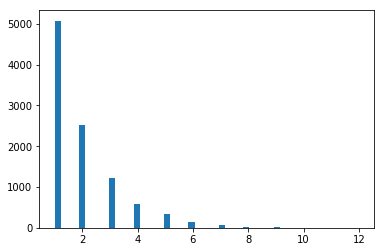

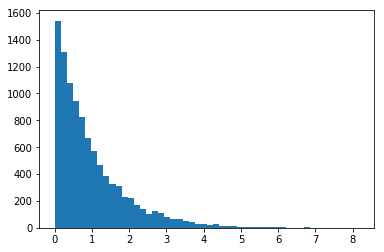

In [167]:
plt.hist(geom_distrib, bins = 50)
plt.show()
plt.hist(expon_distrib, bins = 50)
plt.show()

## Ensemble Methods

微調模型的另一種方法是嘗試將表現最好的模型組合起來。 組合（或'集成'）通常比最佳的單一模型更好（就像隨機森林比其所依賴的任何單個決策樹模型表現更好），特别是當單一模型會產生嚴重不同類型的錯誤時更是如此。

## Analyze the Best Models and Their Errors

RandomForestRegressor 可以指出每個屬性的相對重要程度。

In [168]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

將這些重要性分數顯示在對應的屬性名稱旁：

In [169]:
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # old solution
cat_encoder = full_pipeline.named_transformers_['cat']
#cat_one_hot_attribs = list(encoder.classes_)
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse = True)

[(0.3661589806181342, 'median_income'),
 (0.1647809935615905, 'INLAND'),
 (0.10879295677551573, 'pop_per_hhold'),
 (0.07334423551601242, 'longitude'),
 (0.0629090704826203, 'latitude'),
 (0.05641917918195401, 'rooms_per_hhold'),
 (0.05335107734767581, 'bedrooms_per_room'),
 (0.041143798478729635, 'housing_median_age'),
 (0.014874280890402767, 'population'),
 (0.014672685420543237, 'total_rooms'),
 (0.014257599323407807, 'households'),
 (0.014106483453584102, 'total_bedrooms'),
 (0.010311488326303787, '<1H OCEAN'),
 (0.002856474637320158, 'NEAR OCEAN'),
 (0.00196041559947807, 'NEAR BAY'),
 (6.028038672736599e-05, 'ISLAND')]

## Evaluate Your System on the Test Set

調整模型一陣子後，會擁有一個足夠好的可以執行的模型。 是該在測試集上測試最終模型了。這個過程只需從測試集中獲取預測變量和標籤，運行 full_pipeline 來轉換數據（調用 transform()，而不是 fit_transform()），並評估測試集上的最終模型。

In [170]:
final_model = grid_search.best_estimator_

In [171]:
X_test = strat_test_set.drop('median_house_value', axis = 1)
y_test = strat_test_set['median_house_value'].copy()

In [172]:
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

In [173]:
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [174]:
final_mse

2278174560.2938914

In [175]:
final_rmse

47730.22690385927

如果先前進行了大量的超參數調整，這時的評估結果通常會略遜於之前使用交叉驗證時的表現（因為透過不斷調整，系統在驗證數據上終於表現良好，但在并未知數據集上可能達不到這麼好的效果）， 在這個例子雖然並非如此，但當發生這種情況時，必須抵制調整超參數的誘惑，不要試圖努力讓測試集的結果看起來很好; 因為這些改進在泛化到新的數據集時又會變成徒勞。

# Launch, Monitor, and Maintain Your System

We can compute a 95% confidence interval for the test RMSE

可以計算測試 RMSE 的 95％ 信賴區間

（以下為作者 github 內的內容）

In [176]:
from scipy import stats

In [177]:
confidence = 0.95

In [178]:
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

In [179]:
np.sqrt(stats.t.interval(confidence, m - 1, loc = np.mean(squared_errors), scale = stats.sem(squared_errors)))

array([45685.10470776, 49691.25001878])

In [180]:
# We could compute the interval manually like this:
# 可以手動計算區間，如下所示
tscore = stats.t.ppf((1 + confidence) / 2, df = m - 1)
tmargin = tscore * squared_errors.std(ddof = 1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(45685.10470776014, 49691.25001877871)

Alternatively, we could use a z-scores rather than t-scores

或者，可以使用 z 分數而不是 t 分數

In [181]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(45685.717918136594, 49690.68623889426)

# Extra material

A full pipeline with both preparation and prediction - 完整的管道，包括準備和預測

In [ ]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

In [ ]:
full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

# 心得

在本章節，作者用了一個房地產的項目案例，帶讀者從對於項目的需求、目的，到取得資料，探索資料，利用可視化檢視資料，為機器學習算法進行數據準備，資料轉換，接著訓練模型，微調模型，評估模型等，作了一系列的說明。透過這樣的案例操作，可以清楚知道建立一個機器學習模型系統的流程與關鍵步驟，實在是獲得很多的啟發。特別是建立 Pipline 的做法等，在日後實際問題處理上，透過這樣的機制建立，可以有效減省重複的動作。而個人覺得最重要的還是在一開始在進行項目時的業務目標確認與對其他現行單位所用的資料的了解，因為建模本身不是最終的目標，而是這個模型能夠提供怎樣的效益，才是對公司最有用的。